In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 関数の定義

In [2]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import random
import time
import os
from os import path
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
import matplotlib.pyplot as plt

from keras import models
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Activation, Dropout
#from keras.utils import plot_model
from tensorflow.keras.utils import plot_model
from keras import regularizers

# from pkg.figure_save import figure_save_class

#3D data create begin
def my_makedirs(path):
  if not os.path.isdir(path):
      os.makedirs(path)

def get_path(work_path):
  #dir_base = os.path.abspath('..\\') 
  dir_base = work_path
  print(dir_base)
  return dir_base

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#              3次元データ作成
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def make_data(data_type, dim, sample):
  def _sphere(dim, sample):
      # z: (sample, dim)
      z = np.random.randn(sample, dim)
      r = np.linalg.norm(z, axis= 1).reshape(sample, 1)
      return np.divide(z,r)
  def _uniform(dim, sample, range):
      r = np.random.random((sample, dim))
      return (range[1]-range[0])*r+range[0]

  if data_type==1:
      # s: (sample, dim)
      s = _sphere(dim, sample)
  elif data_type==2:
      r1 = 0
      r2 = 1
      # s: (sample, dim)
      s = _sphere(dim, sample)
      # r: (sample, dim)
      r = _uniform(dim, sample, [r1, r2])
      r = np.power(r, 1./dim)
      s = s*r
  elif data_type==3:
      #%%%%%%%%%%%%%%%%%%パラメータ設定%%%%%%%%%%%%%%%%%%
      #r1 = 0.05
      #r2 = 1
      r1 = 1
      r2 = 1
      # s: (sample, dim)
      s = _sphere(dim, sample)
      # r: (sample, dim)
      r = _uniform(dim, sample, [r1, r2])
      r = np.power(r, 1./dim)
      s = s*r
  s_df = pd.DataFrame(s)
  # piece
  for i in range(0, dim):
      s_df = s_df[s_df.loc[:, i]>0]
  return s_df


def draw_scatter_chart(df, fig_file_name):
  fig = plt.figure(figsize=(6,6))
  fig.patch.set_facecolor('white')

  if df.values.shape[1] == 3:
      x1 = df.loc[:,0].values
      x2 = df.loc[:,1].values
      x3 = df.loc[:,2].values
      ax = fig.add_subplot(111, projection='3d')
      ax.scatter(x1, x2, x3, marker="o", s=8, alpha=0.8)
      # plot angle
      # ax.view_init(elev=60, azim=120)
      ax.set_xlabel('x1', fontsize=10)
      ax.set_ylabel('x2', fontsize=10)
      ax.set_zlabel('x3', fontsize=10)

  elif df.values.shape[1] == 2:
      x1 = df.loc[:,0].values
      x2 = df.loc[:,1].values
      ax = fig.add_subplot(1,1,1)        
      ax.scatter(x1, x2, s=10)
      ax.set_xlabel('x1', fontsize=10)
      ax.set_ylabel('x2', fontsize=10)

  ax.tick_params(direction = "in")
  plt.tick_params(labelsize=8)
  plt.tight_layout()
  plt.savefig(fig_file_name, bbox_inches="tight")

#3D data create end

#2D data create bigin
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#              2次元データ作成
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def get_rotated(X, t, deg=False):
  def rotation_matrix_2D(t):
      R = np.array([[np.cos(t), -np.sin(t)],
                    [np.sin(t),  np.cos(t)]])
      return R

  # if deg == True, degree
  # if deg == False, radian
  if deg == True:
      t = np.deg2rad(t)

  R = rotation_matrix_2D(t)

  return  np.dot(X, R)

def ori_datasets(type_, samples_, features_):
  if type_ == 1:
      # features = 2
      data, target = datasets.make_moons(n_samples=samples_, random_state=123)
      target_list = np.unique(target)
      ori_new_data = data[target==target_list[0], :]
      ori_new_data[:, 1] = ori_new_data[:, 1] - 0.5
      new_data = np.concatenate([ori_new_data, ori_new_data, ori_new_data])
      for i in range(0,3):
          random.seed(i)
          new_data[i*len(ori_new_data):(i+1)*len(ori_new_data), 1] = ori_new_data[:, 1] + np.random.randn(len(ori_new_data))*0.1
      new_data = get_rotated(new_data, np.pi/6)
  return new_data

def scaling_scaled(data_0):
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler.fit(data_0)
  min_ = scaler.data_min_
  max_ = scaler.data_max_
  def scaling(data):
      array_scaler = scaler.transform(data)
      return array_scaler
  def scaled(data):
      array_unscaler = scaler.inverse_transform(data)
      return array_unscaler
  return scaling, scaled

def arc_func(CoM,Radius,x):
  y = np.sqrt(Radius**2 - ((x - CoM[0])**2)) + CoM[1]
  # print(Radius**2,((x - CoM[0])**2) )
  return y

def circle_param(Curvature,Angle):
  CoM = np.zeros(2)
  if Curvature == 0:
      Radius = 1/(Curvature+0.0001)
  else:
      Radius = 1/Curvature
  x = Radius * np.cos(np.pi/2 - Angle/360*2*np.pi/2)
  y1 = Radius * np.sin(np.pi/2 - Angle/360*2*np.pi/2)
  y2 = Radius
  xlim = x
  CoM[0] = 0
  CoM[1] = -(y1 + y2) / 2
  return CoM, Radius, xlim    

def rotation(Data,CoM):
  rt = 3
  temp = (Data[:,0] - CoM[0]) * np.sin(np.pi*rt/4) - (Data[:,1] - CoM[1]) * np.cos(np.pi*rt/4) + CoM[0]
  Data[:,1] = (Data[:,0] - CoM[0]) * np.cos(np.pi*rt/4) + (Data[:,1] - CoM[1]) * np.sin(np.pi*rt/4) + CoM[1]
  Data[:,0] = temp
  # print(Data)
  xmedium = np.max(Data[:,0]) + np.min(Data[:,0])
  ymedium = np.max(Data[:,1]) + np.min(Data[:,1])
  Data[:,0] -= xmedium/2
  Data[:,1] -= ymedium/2
  
  return Data

def data_create(Curvature,Angle,Mean,Val,DataNum):
  Data = np.zeros(DataNum*2).reshape(-1,2)
  CoM, Radius, xlim = circle_param(Curvature,Angle)
  Data[:,0] = (np.random.rand(DataNum) - 0.5) * 2 * xlim
  Data[:,1] = arc_func(CoM,Radius,Data[:,0])
  Data = rotation(Data,CoM)
  Data[:,0] += np.random.normal(Mean,Val,(DataNum,))
  Data[:,1] += np.random.normal(Mean,Val,(DataNum,))
  
  return Data, xlim
#2D data create end


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#              ネットワーク構築
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def build_NN(X_train, hidden_units, layer_num, incom_num, node_num):
  # input and output units
  in_neurons = X_train.shape[1]
  # input and output units
  out_neurons = X_train.shape[1]
  # hidden units
  hidden_neurons = hidden_units

  #%%%%%%%%%%%%%%%%%%パラメータ設定begin%%%%%%%%%%%%%%%%%%
  num_of_training_epochs = 1500 #エポック数

  # 10~20
  minibatch_size = 20 #ミニバッチ数

  # 1:rmsprop, 2:adam
  optimizertype = 2
 
  #活性化関数
  # actfunc1 = 'relu'
  # actfunc1 = 'gelu'
  # actfunc1 = 'elu'
  actfunc1 = 'PReLU'
  # actfunc1 = 'sigmoid'
  # actfunc1 = 'selu'
  # actfunc1 = 'tanh'
  # actfunc2 = 'sigmoid'
  # actfunc2 = 'gelu'
  actfunc2 = 'tanh'
  # actfunc2 = 'elu'
  # actfunc2 = 'PReLU'
  # actfunc2 = 'selu'
  # actfunc2 = 'identity'



  if optimizertype == 1:
    optimizer = 'rmsprop'
  elif optimizertype == 2:
    optimizer = 'adam'
    #optimizer = 'Adamax'

  #損失関数
  #loss_fn = tf.keras.losses.MeanAbsolutePercentageError()
  # loss_fn = "mean_squared_logarithmic_error"
  # loss_fn = "mean_absolute_error"
  # loss_fn = "cosine_similarity"
  # loss_fn = "log_cosh"
  loss_fn = 'mean_squared_error'

  model = Sequential()
  reg_mean = 0.0 #各ノード印加外乱平均値確率
  dropout_pct = 0.1 #ドロップアウト確率
  #%%%%%%%%%%%%%%%%%%パラメータ設定end%%%%%%%%%%%%%%%%%%
  # model.add(Dense(hidden_neurons, input_shape=(in_neurons,),activity_regularizer=keras.regularizers.l1(0.1)))
  if layer_num == 1:
      model.add(Dense(hidden_neurons, input_shape=(in_neurons,)))
      model.add(Activation(actfunc1))
      model.add(BatchNormalization())
      model.add(Dense(out_neurons))
      if actfunc2 != 'identity':
          model.add(Activation(actfunc2))
      model.summary()
  else:
      for it in range(layer_num):
          if it == 0:
              model.add(Dense(node_num, input_shape=(in_neurons,),activity_regularizer=keras.regularizers.l1(reg_mean)))
              model.add(BatchNormalization())
              model.add(Activation(actfunc1))
              model.add(Dropout(dropout_pct))
              # model.add(BatchNormalization())
          elif it < incom_num:
              model.add(Dense(node_num, input_shape=(node_num,),activity_regularizer=keras.regularizers.l1(reg_mean)))
              model.add(BatchNormalization())
              model.add(Activation(actfunc1))
              model.add(Dropout(dropout_pct))
              # model.add(BatchNormalization())
          elif it == incom_num:
              model.add(Dense(hidden_neurons, input_shape=(node_num,),activity_regularizer=keras.regularizers.l1(reg_mean)))
              # model.add(BatchNormalization())
              model.add(Activation(actfunc1))
              # model.add(BatchNormalization())
          else:
              model.add(Dense(hidden_neurons, input_shape=(hidden_neurons,),activity_regularizer=keras.regularizers.l1(reg_mean)))
              # model.add(BatchNormalization())
              model.add(Activation(actfunc1))
              # model.add(BatchNormalization())

      # model.add(BatchNormalization())
      layer_decode = (layer_num-1)*4 + 1
      for it in range(layer_num):
          if it < (layer_num - incom_num -1):
              model.add(Dense(hidden_neurons, input_shape=(hidden_neurons,),activity_regularizer=keras.regularizers.l1(reg_mean)))
              model.add(BatchNormalization())
              model.add(Activation(actfunc1))
              model.add(Dropout(dropout_pct))
              # model.add(BatchNormalization())
          elif it == (layer_num - incom_num -1):
              model.add(Dense(node_num, input_shape=(hidden_neurons,),activity_regularizer=keras.regularizers.l1(reg_mean)))
              model.add(BatchNormalization())
              model.add(Activation(actfunc1))
              model.add(Dropout(dropout_pct))
              # model.add(BatchNormalization())
          elif it < layer_num -1:
              model.add(Dense(node_num, input_shape=(node_num,),activity_regularizer=keras.regularizers.l1(reg_mean)))
              model.add(BatchNormalization())
              model.add(Activation(actfunc1))
              model.add(Dropout(dropout_pct))
              # model.add(BatchNormalization())    
          else:
              model.add(Dense(out_neurons))
              if actfunc2 != 'identity':
                  layer_decode += 1
                  model.add(Activation(actfunc2))
      model.summary()

  model.compile(loss=loss_fn, optimizer=optimizer)
  history = model.fit(X_train, X_train, batch_size=minibatch_size, epochs=num_of_training_epochs, validation_split=0.05)

  encoder = models.clone_model(model)
  encoder.compile(loss=loss_fn, optimizer=optimizer)
  encoder.set_weights(model.get_weights())
  # delete final layer
  # encoder.pop()
  for it in range(layer_decode):
      encoder.pop()
  # encoder.summary()

  def transformed(new_X):
      z = encoder.predict(new_X, verbose=0)
      return z

  def encode_decode(new_X):
      outputX = model.predict(new_X, verbose=0)
      return outputX

  return transformed, encode_decode, history, model




In [3]:
#coding: utf-8 
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
plt.rcParams['font.family'] = 'Times New Roman'

class figure_save_class:
    def principal_component_contour(self, figure_label, X, Y, Z, train_data, fig_file_name):
        title_name = figure_label[0]
        x_label_name = figure_label[1]
        y_label_name = figure_label[2]
        label_name = figure_label[3]
        xmin = figure_label[4]
        xmax = figure_label[5]
        ymin = figure_label[6]
        ymax = figure_label[7]

        fig = plt.figure(figsize=(6,5))
        ax = fig.add_subplot(1,1,1)

        con = ax.contour(X, Y, Z, 20, linewidths=0.75, cmap=cm.jet)
        ax.scatter(train_data[:, 0], train_data[:, 1], s=4, label=label_name)
        cbar = fig.colorbar(con)

        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title(title_name)
        ax.set_xlabel(x_label_name, fontsize=16)
        ax.set_ylabel(y_label_name, fontsize=16)
        ax.tick_params(direction = "in")

        plt.legend(loc='upper right', fontsize=12)
        plt.tick_params(labelsize=12)
        plt.tight_layout()
        plt.savefig(fig_file_name)
        plt.close()

    
    def principal_component_contourf_3D(self, figure_label, X, Y, Z, train_data, fig_file_name):
        title_name = figure_label[0]
        x_label_name = figure_label[1]
        y_label_name = figure_label[2]
        z_label_name = figure_label[3]
        label_name = figure_label[4]
        xmin = figure_label[5]
        xmax = figure_label[6]
        ymin = figure_label[7]
        ymax = figure_label[8]
        zmin = figure_label[9]
        zmax = figure_label[10]

        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(1,1,1, projection='3d')

        # ax.contourf(X, Y, Z, alpha=0.4, cmap='Greys')
        
        # ax.plot_surface(X, Y, Z.reshape(1,-1))
        ax.scatter(train_data[:, 0], train_data[:, 1], train_data[:, 2], s=4, label=label_name)

        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_zlim(zmin, zmax)
        ax.set_title(title_name)
        ax.set_xlabel(x_label_name, fontsize=16)
        ax.set_ylabel(y_label_name, fontsize=16)
        ax.set_zlabel(z_label_name, fontsize=16)
        ax.tick_params(direction = "in")

        plt.legend(loc='upper right', fontsize=12)
        plt.tick_params(labelsize=12)
        plt.tight_layout()
        plt.savefig(fig_file_name)
        plt.close()


    def twoD_plot(self, figure_label, x1, x2, fig_file_name):
        title_name = figure_label[0]
        x_label_name = figure_label[1]
        y_label_name = figure_label[2]
        label_name = figure_label[3]
        xmin = figure_label[4]
        xmax = figure_label[5]
        ymin = figure_label[6]
        ymax = figure_label[7]

        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(1,1,1)
        ax.scatter(x1, x2, s=4, label=label_name)

        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        ax.set_xlabel(x_label_name, fontsize=16)
        ax.set_ylabel(y_label_name, fontsize=16)
        ax.tick_params(direction = "in")

        plt.legend(loc='upper right', fontsize=12)
        plt.tick_params(labelsize=12)
        plt.tight_layout()
        plt.savefig(fig_file_name)
        plt.close()

    def twoD_plot_3D(self, figure_label, x1, x2, x3, fig_file_name):
        title_name = figure_label[0]
        x_label_name = figure_label[1]
        y_label_name = figure_label[2]
        z_label_name = figure_label[3]
        label_name = figure_label[4]
        xmin = figure_label[5]
        xmax = figure_label[6]
        ymin = figure_label[7]
        ymax = figure_label[8]
        zmin = figure_label[9]
        zmax = figure_label[10]

        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(1,1,1, projection='3d')
        ax.scatter(x1, x2, x3, s=4, label=label_name)

        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        ax.set_zlim([zmin, zmax])
        ax.set_xlabel(x_label_name, fontsize=16)
        ax.set_ylabel(y_label_name, fontsize=16)
        ax.set_zlabel(z_label_name, fontsize=16)
        ax.tick_params(direction = "in")

        plt.legend(loc='upper right', fontsize=12)
        plt.tick_params(labelsize=12)
        plt.tight_layout()
        plt.savefig(fig_file_name)
        plt.close()

    def scatter_decode_data(self, figure_label, x1, x2, z1, z2, fig_file_name):
        x_label_name = figure_label[0]
        y_label_name = figure_label[1]
        label1_name = figure_label[2]
        label2_name = figure_label[3]
        label3_name = figure_label[4]
        label4_name = figure_label[5]
        xmin = figure_label[6]
        xmax = figure_label[7]
        ymin = figure_label[8]
        ymax = figure_label[9]

        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(1,1,1)
        ax.scatter(x2[:,0], x2[:,1], s=2, facecolor='None', edgecolors='orange', lw=0.3, label=label2_name)
        ax.scatter(x1[:,0], x1[:,1], marker='o', s=4, facecolor='None', edgecolors='blue', label=label1_name)
        ax.scatter(z2[:,0], z2[:,1], s=2, facecolor='None', edgecolors='green', lw=0.3, label=label4_name)
        ax.scatter(z1[:,0], z1[:,1], marker='o', s=4, facecolor='None', edgecolors='red', label=label3_name)

        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        ax.set_xlabel(x_label_name, fontsize=16)
        ax.set_ylabel(y_label_name, fontsize=16)
        ax.tick_params(direction = "in")

        plt.legend(loc='lower left', fontsize=12)
        plt.tick_params(labelsize=12)
        plt.tight_layout()
        plt.savefig(fig_file_name)
        plt.close()

    def scatter_decode_data_3D(self, figure_label, x1, x2, z1, z2, fig_file_name):
        x_label_name = figure_label[0]
        y_label_name = figure_label[1]
        z_label_name = figure_label[2]
        label1_name = figure_label[3]
        label2_name = figure_label[4]
        label3_name = figure_label[5]
        label4_name = figure_label[6]
        xmin = figure_label[7]
        xmax = figure_label[8]
        ymin = figure_label[9]
        ymax = figure_label[10]
        zmin = figure_label[11]
        zmax = figure_label[12]

        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(1,1,1, projection='3d')
        ax.scatter(x2[:,0], x2[:,1], x2[:,2], s=2, facecolor='None', edgecolors='orange', lw=0.3, label=label2_name)
        ax.scatter(x1[:,0], x1[:,1], x1[:,2], marker='o', s=4, facecolor='None', edgecolors='blue', label=label1_name)
        ax.scatter(z2[:,0], z2[:,1], z2[:,2], s=2, facecolor='None', edgecolors='green', lw=0.3, label=label4_name)
        ax.scatter(z1[:,0], z1[:,1], z1[:,2], marker='o', s=4, facecolor='None', edgecolors='red', label=label3_name)

        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        ax.set_zlim([zmin, zmax])
        ax.set_xlabel(x_label_name, fontsize=16)
        ax.set_ylabel(y_label_name, fontsize=16)
        ax.set_zlabel(z_label_name, fontsize=16)
        ax.tick_params(direction = "in")

        plt.legend(loc='lower left', fontsize=12)
        plt.tick_params(labelsize=12)
        plt.tight_layout()
        plt.savefig(fig_file_name)
        plt.close()

    def scatter_feature_2D(self, figure_label, z1, z2, train_z1, train_z2, fig_file_name):
        title_name = figure_label[0]
        x_label_name = figure_label[1]
        y_label_name = figure_label[2]
        label1_name = figure_label[3]
        label2_name = figure_label[4]

        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(1,1,1)
        ax.scatter(z1, z2, s=2, facecolor='None', edgecolors='orange', lw=0.3, label=label1_name)
        ax.scatter(train_z1, train_z2, marker='o', s=4, label=label2_name)

        ax.set_xlabel(x_label_name, fontsize=16)
        ax.set_ylabel(y_label_name, fontsize=16)
        ax.tick_params(direction = "in")
        ax.set_title(title_name)

        plt.legend(loc='upper right', fontsize=12)
        plt.tick_params(labelsize=12)
        plt.tight_layout()
        plt.savefig(fig_file_name)
        plt.close()

    def scatter_feature_2D_3D(self, figure_label, z1, z2, train_z1, train_z2, fig_file_name):
        title_name = figure_label[0]
        x_label_name = figure_label[1]
        y_label_name = figure_label[2]
        z_label_name = figure_label[3]
        label1_name = figure_label[4]
        label2_name = figure_label[5]

        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(1,1,1 , projection='3d')
        ax.scatter(z1, z2, s=2, facecolor='None', edgecolors='orange', lw=0.3, label=label1_name)
        ax.scatter(train_z1, train_z2, marker='o', s=4, label=label2_name)

        ax.set_xlabel(x_label_name, fontsize=16)
        ax.set_ylabel(y_label_name, fontsize=16)
        ax.set_zlabel(z_label_name, fontsize=16)
        ax.tick_params(direction = "in")
        ax.set_title(title_name)

        plt.legend(loc='upper right', fontsize=12)
        plt.tick_params(labelsize=12)
        plt.tight_layout()
        plt.savefig(fig_file_name)
        plt.close()

    def trend1(self, figure_label, y1, y2, fig_file_name):
        x_label_name = figure_label[0]
        y_label_name = figure_label[1]
        y1_legend_name = figure_label[2]
        y2_legend_name = figure_label[3]
        xmin = 0
        xmax = len(y1)

        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot(1,1,1)
        ax.plot(y1, "C0", label=y1_legend_name, lw=0.5)
        ax.plot(y2, "C1", label=y2_legend_name, lw=0.5)
        ax.set_xlabel(x_label_name, fontsize=16)
        ax.set_ylabel(y_label_name, fontsize=16)
        ax.tick_params(direction = "in")
        ax.grid(linestyle='dashdot')

        ax.set_xlim([xmin, xmax])

        ax.legend(loc='upper right')
        plt.tick_params(labelsize=12)
        plt.tight_layout()
        plt.savefig(fig_file_name, bbox_inches="tight")
        plt.close()
    
    def trend1_3D(self, figure_label, y1, y2, fig_file_name):
        x_label_name = figure_label[0]
        y_label_name = figure_label[1]
        y1_legend_name = figure_label[2]
        y2_legend_name = figure_label[3]
        xmin = 0
        xmax = len(y1)

        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot(1,1,1)
        ax.plot(y1, "C0", label=y1_legend_name, lw=0.5)
        ax.plot(y2, "C1", label=y2_legend_name, lw=0.5)
        ax.set_xlabel(x_label_name, fontsize=16)
        ax.set_ylabel(y_label_name, fontsize=16)
        ax.tick_params(direction = "in")
        ax.grid(linestyle='dashdot')

        ax.set_xlim([xmin, xmax])

        ax.legend(loc='upper right')
        plt.tick_params(labelsize=12)
        plt.tight_layout()
        plt.savefig(fig_file_name, bbox_inches="tight")
        plt.close()


In [4]:
# time start
time_start = time.time()
print ("started.")

# data load
ori_num_samples = 100
# 2次元データ用
# Curvature = 1
# Angle = 90
# Val = 1/Curvature/30
# DataNum = 200
# train_data, xlimsave = data_create(Curvature,Angle,0,Val,DataNum)

# 3次元データ用
sample = 1000
dim = 3
train_data = make_data(3, dim, sample).values
num_samples = len(train_data)
print("train data = ", train_data.shape)

print ("file import finished.")

xmin = -0.2
xmax = 1.0
ymin = -0.2
ymax = 1.0
zmin = -0.2
zmax = 1.0
#xmin = -0.5
#xmax = 1.5
#ymin = -0.5
#ymax = 1.5

# new data (grid positions in input space (2D))
num_mesh = int(num_samples/3)
x = np.linspace(xmin,xmax,num_mesh)
y = np.linspace(ymin,ymax,num_mesh)
z = np.linspace(zmin,zmax,num_mesh)
X, Y, Z = np.meshgrid(x,y,z)

new_X = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1)], 1)
new_X = np.concatenate([new_X, Z.reshape(-1,1)], 1)
print("new_X = ", new_X.shape)

# scaling
(scaling, scaled) = scaling_scaled(new_X)
train_data = scaling(train_data)
new_X = scaling(new_X)

# get insctances of AE

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#レイヤー設定
hidden_units = 3
epsilon = 0.5
layer_num = 6
incom_num = layer_num-1
node_num = 64
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
(transformed, encode_decode, history, model) = build_NN(train_data, hidden_units, layer_num, incom_num, node_num)
plot1 = history.history["loss"]
plot2 = history.history["val_loss"]

print ("training finished.")
time_end = time.time()
time_ = time_end - time_start
print("time = {:.2f} sec".format(time_))


# transform
train_z = transformed(train_data)
z = transformed(new_X)
print('z = ',z)
estimate_train_X = encode_decode(train_data)
predict_new_X = encode_decode(new_X)

print("train Z = ", train_z.shape)
print("new Z = ", z.shape)
print("estimate train X = ", estimate_train_X.shape)
print("predict new X = ", predict_new_X.shape)

feas_box = np.where((z>-1*epsilon) & (z<epsilon), 1, -1)

print ("transform finished.")
time_end = time.time()
time_ = time_end - time_start
print("time = {:.2f} sec".format(time_))

started.
train data =  (125, 3)
file import finished.
new_X =  (68921, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                64        
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Batc  (None, 64)        

# plot

i= 1
Z (41, 41, 41) Y (41, 41, 41) X (41, 41, 41)
i= 2
Z (41, 41, 41) Y (41, 41, 41) X (41, 41, 41)
i= 3
Z (41, 41, 41) Y (41, 41, 41) X (41, 41, 41)


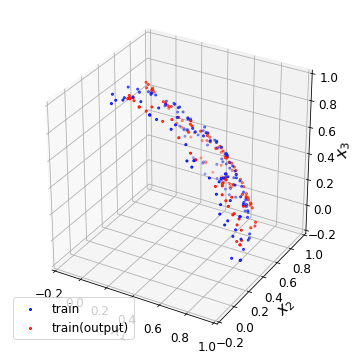

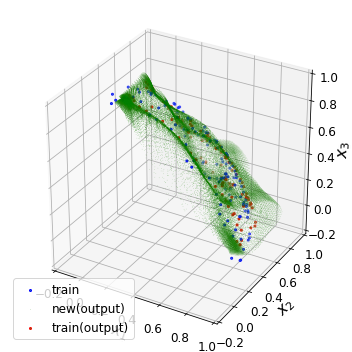

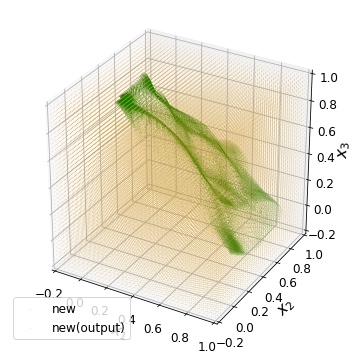

In [5]:
# get path
work_path = os.getcwd()
dir_base = work_path + '/output/'



train_data = scaled(train_data)
new_X = scaled(new_X)
estimate_train_X = scaled(estimate_train_X)
predict_new_X = scaled(predict_new_X)

x_label_name = "$x_1$"
y_label_name = "$x_2$"
z_label_name = "$x_3$"

# figure save
# i-th principal component in grid positions of input space
for i in range(0, hidden_units):
    
    print("i=", i+1)

    # i-th principal component in grid positions of input space
    Z = z[:, i].reshape(num_mesh, num_mesh, num_mesh)
    #Z = [comp_scalar_pc([x,y], i) for (x,y) in zip(X,Y)]
    print('Z',np.shape(Z),'Y',np.shape(Y),'X',np.shape(X))

    # feas/infeas map
    F = feas_box[:, i].reshape(num_mesh, num_mesh, num_mesh)

    if np.all(Z!=0):
        fig_file_name = dir_base + "fig/AE_contour_PC" + str(i+1) + ".png"
        # figure_label = ['PC'+str(i+1), x_label_name, y_label_name, "train", xmin, xmax, ymin, ymax]
        figure_label = ['PC'+str(i+1), x_label_name, y_label_name,z_label_name, "train", xmin, xmax, ymin, ymax, zmin, zmax]
        # figure_save_class().principal_component_contourf_3D(figure_label, X, Y, Z, train_data, fig_file_name)
    else:
        print("all Z=0")
        print("contour skip")


    if np.all(F==1):
        print("all F=1")
        print("contourf skip")
    else:
        fig_file_name = dir_base + "fig/AE_contourf_PC" + str(i+1) + ".png"
        figure_label = ['PC'+str(i+1) + "_$\epsilon$=" + str(epsilon), x_label_name, y_label_name, z_label_name, "train", xmin, xmax, ymin, ymax, zmin, zmax]
        # figure_save_class().principal_component_contourf_3D(figure_label, X, Y, F, train_data, fig_file_name)


# decode data in input space
fig_file_name = dir_base + "fig/AE_scatter_decode.png"
figure_label = [x_label_name, y_label_name, z_label_name, "train", "new", "train(output)", "new(output)", xmin, xmax, ymin, ymax, zmin, zmax]
x_label_name = figure_label[0]
y_label_name = figure_label[1]
z_label_name = figure_label[2]
label1_name = figure_label[3]
label2_name = figure_label[4]
label3_name = figure_label[5]
label4_name = figure_label[6]
xmin = figure_label[7]
xmax = figure_label[8]
ymin = figure_label[9]
ymax = figure_label[10]
zmin = figure_label[11]
zmax = figure_label[12]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
# ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], s=0.1, edgecolors='orange', lw=0.3, label=label2_name)
ax.scatter(train_data[:,0], train_data[:,1], train_data[:,2], marker='o', s=4, edgecolors='blue', label=label1_name)
# ax.scatter(predict_new_X[:,0], predict_new_X[:,1], predict_new_X[:,2], s=0.02, edgecolors='green', lw=0.3, label=label4_name)
ax.scatter(estimate_train_X[:,0], estimate_train_X[:,1], estimate_train_X[:,2], marker='o', s=4, edgecolors='red', label=label3_name)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_zlim([zmin, zmax])
ax.set_xlabel(x_label_name, fontsize=16)
ax.set_ylabel(y_label_name, fontsize=16)
ax.set_zlabel(z_label_name, fontsize=16)
ax.tick_params(direction = "in")

plt.legend(loc='lower left', fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()
plt.close()
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
# ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], s=0.1, edgecolors='orange', lw=0.3, label=label2_name)
ax.scatter(train_data[:,0], train_data[:,1], train_data[:,2], marker='o', s=4, edgecolors='blue', label=label1_name)
ax.scatter(predict_new_X[:,0], predict_new_X[:,1], predict_new_X[:,2], s=0.02, edgecolors='green', lw=0.3, label=label4_name)
ax.scatter(estimate_train_X[:,0], estimate_train_X[:,1], estimate_train_X[:,2], marker='o', s=4, edgecolors='red', label=label3_name)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_zlim([zmin, zmax])
ax.set_xlabel(x_label_name, fontsize=16)
ax.set_ylabel(y_label_name, fontsize=16)
ax.set_zlabel(z_label_name, fontsize=16)
ax.tick_params(direction = "in")

plt.legend(loc='lower left', fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()
plt.close()
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], s=0.1, edgecolors='orange', lw=0.3, label=label2_name)
# ax.scatter(train_data[:,0], train_data[:,1], train_data[:,2], marker='o', s=4, edgecolors='blue', label=label1_name)
ax.scatter(predict_new_X[:,0], predict_new_X[:,1], predict_new_X[:,2], s=0.02, edgecolors='green', lw=0.3, label=label4_name)
# ax.scatter(estimate_train_X[:,0], estimate_train_X[:,1], estimate_train_X[:,2], marker='o', s=4, edgecolors='red', label=label3_name)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_zlim([zmin, zmax])
ax.set_xlabel(x_label_name, fontsize=16)
ax.set_ylabel(y_label_name, fontsize=16)
ax.set_zlabel(z_label_name, fontsize=16)
ax.tick_params(direction = "in")

plt.legend(loc='lower left', fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()
plt.close()
# figure_save_class().scatter_decode_data_3D(figure_label, train_data, new_X, estimate_train_X, predict_new_X, fig_file_name)



# 

## ペナルティ計算

In [6]:
dif = new_X - predict_new_X
penalty = np.sqrt(sum(map(lambda i: i**2, dif.T)))
epsilon1 = 0.1
plot_penalty = penalty-epsilon1
plot_penalty = np.clip(plot_penalty,0,None)
for it in range(len(plot_penalty)):
  if plot_penalty[it] == 0:
    plot_penalty[it] = -np.max(plot_penalty)/2

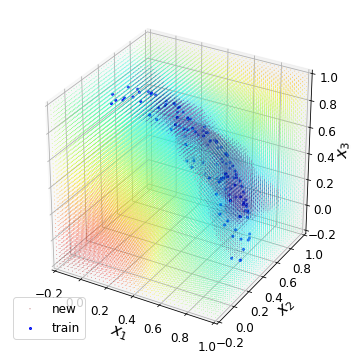

In [7]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], s=0.1, c=plot_penalty, cmap='jet', lw=0.5, label=label2_name)
ax.scatter(train_data[:,0], train_data[:,1], train_data[:,2], marker='o', s=4, edgecolors='blue', label=label1_name)
# ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], s=0.1, edgecolors='orange', lw=0.3, label=label2_name)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_zlim([zmin, zmax])
ax.set_xlabel(x_label_name, fontsize=16)
ax.set_ylabel(y_label_name, fontsize=16)
ax.set_zlabel(z_label_name, fontsize=16)
ax.tick_params(direction = "in")

plt.legend(loc='lower left', fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

In [8]:
# penalty 保存
import copy
save_penalty = copy.deepcopy(penalty)

# 2回目のモデル計算（不必要な場合は以下すべてのコード実行不要）

In [9]:
# scaling
(scaling, scaled) = scaling_scaled(new_X)
train_data = scaling(train_data)
new_X = scaling(new_X)

# get insctances of AE
hidden_units = 2
epsilon = 0.5
layer_num = 8
incom_num = layer_num-1
node_num = 64

(transformed, encode_decode, history, model) = build_NN(train_data, hidden_units, layer_num, incom_num, node_num)
plot1 = history.history["loss"]
plot2 = history.history["val_loss"]

print ("training finished.")
time_end = time.time()
time_ = time_end - time_start
print("time = {:.2f} sec".format(time_))


# transform
train_z = transformed(train_data)
z = transformed(new_X)
print('z = ',z)
estimate_train_X = encode_decode(train_data)
predict_new_X = encode_decode(new_X)

print("train Z = ", train_z.shape)
print("new Z = ", z.shape)
print("estimate train X = ", estimate_train_X.shape)
print("predict new X = ", predict_new_X.shape)

feas_box = np.where((z>-1*epsilon) & (z<epsilon), 1, -1)

print ("transform finished.")
time_end = time.time()
time_ = time_end - time_start
print("time = {:.2f} sec".format(time_))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                256       
                                                                 
 batch_normalization_10 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 64)                64        
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_11 (Bat  (None, 64)               256       
 chNormalization)                                     

## plot

i= 1
Z (41, 41, 41) Y (41, 41, 41) X (41, 41, 41)
i= 2
Z (41, 41, 41) Y (41, 41, 41) X (41, 41, 41)


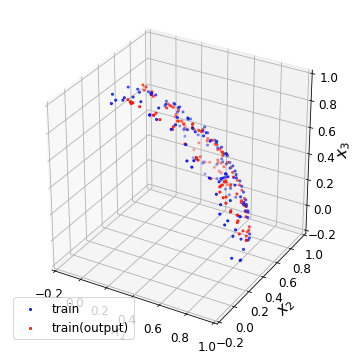

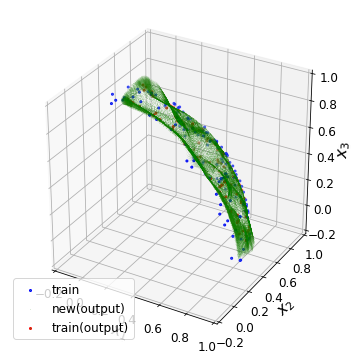

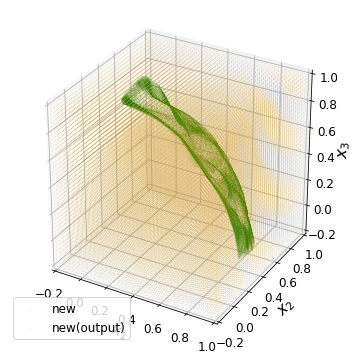

In [10]:
train_data = scaled(train_data)
new_X = scaled(new_X)
estimate_train_X = scaled(estimate_train_X)
predict_new_X = scaled(predict_new_X)

# figure save
# i-th principal component in grid positions of input space
for i in range(0, hidden_units):
    
    print("i=", i+1)

    # i-th principal component in grid positions of input space
    Z = z[:, i].reshape(num_mesh, num_mesh, num_mesh)
    #Z = [comp_scalar_pc([x,y], i) for (x,y) in zip(X,Y)]
    print('Z',np.shape(Z),'Y',np.shape(Y),'X',np.shape(X))

    # feas/infeas map
    F = feas_box[:, i].reshape(num_mesh, num_mesh, num_mesh)

    if np.all(Z!=0):
        fig_file_name = dir_base + "fig/AE_contour_PC" + str(i+1) + ".png"
        # figure_label = ['PC'+str(i+1), x_label_name, y_label_name, "train", xmin, xmax, ymin, ymax]
        figure_label = ['PC'+str(i+1), x_label_name, y_label_name,z_label_name, "train", xmin, xmax, ymin, ymax, zmin, zmax]
        # figure_save_class().principal_component_contourf_3D(figure_label, X, Y, Z, train_data, fig_file_name)
    else:
        print("all Z=0")
        print("contour skip")


    if np.all(F==1):
        print("all F=1")
        print("contourf skip")
    else:
        fig_file_name = dir_base + "fig/AE_contourf_PC" + str(i+1) + ".png"
        figure_label = ['PC'+str(i+1) + "_$\epsilon$=" + str(epsilon), x_label_name, y_label_name, z_label_name, "train", xmin, xmax, ymin, ymax, zmin, zmax]
        # figure_save_class().principal_component_contourf_3D(figure_label, X, Y, F, train_data, fig_file_name)


# decode data in input space
fig_file_name = dir_base + "fig/AE_scatter_decode.png"
figure_label = [x_label_name, y_label_name, z_label_name, "train", "new", "train(output)", "new(output)", xmin, xmax, ymin, ymax, zmin, zmax]
x_label_name = figure_label[0]
y_label_name = figure_label[1]
z_label_name = figure_label[2]
label1_name = figure_label[3]
label2_name = figure_label[4]
label3_name = figure_label[5]
label4_name = figure_label[6]
xmin = figure_label[7]
xmax = figure_label[8]
ymin = figure_label[9]
ymax = figure_label[10]
zmin = figure_label[11]
zmax = figure_label[12]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
# ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], s=0.1, edgecolors='orange', lw=0.3, label=label2_name)
ax.scatter(train_data[:,0], train_data[:,1], train_data[:,2], marker='o', s=4, edgecolors='blue', label=label1_name)
# ax.scatter(predict_new_X[:,0], predict_new_X[:,1], predict_new_X[:,2], s=0.02, edgecolors='green', lw=0.3, label=label4_name)
ax.scatter(estimate_train_X[:,0], estimate_train_X[:,1], estimate_train_X[:,2], marker='o', s=4, edgecolors='red', label=label3_name)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_zlim([zmin, zmax])
ax.set_xlabel(x_label_name, fontsize=16)
ax.set_ylabel(y_label_name, fontsize=16)
ax.set_zlabel(z_label_name, fontsize=16)
ax.tick_params(direction = "in")

plt.legend(loc='lower left', fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()
plt.close()
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
# ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], s=0.1, edgecolors='orange', lw=0.3, label=label2_name)
ax.scatter(train_data[:,0], train_data[:,1], train_data[:,2], marker='o', s=4, edgecolors='blue', label=label1_name)
ax.scatter(predict_new_X[:,0], predict_new_X[:,1], predict_new_X[:,2], s=0.02, edgecolors='green', lw=0.3, label=label4_name)
ax.scatter(estimate_train_X[:,0], estimate_train_X[:,1], estimate_train_X[:,2], marker='o', s=4, edgecolors='red', label=label3_name)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_zlim([zmin, zmax])
ax.set_xlabel(x_label_name, fontsize=16)
ax.set_ylabel(y_label_name, fontsize=16)
ax.set_zlabel(z_label_name, fontsize=16)
ax.tick_params(direction = "in")

plt.legend(loc='lower left', fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()
plt.close()
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], s=0.1, edgecolors='orange', lw=0.3, label=label2_name)
# ax.scatter(train_data[:,0], train_data[:,1], train_data[:,2], marker='o', s=4, edgecolors='blue', label=label1_name)
ax.scatter(predict_new_X[:,0], predict_new_X[:,1], predict_new_X[:,2], s=0.02, edgecolors='green', lw=0.3, label=label4_name)
# ax.scatter(estimate_train_X[:,0], estimate_train_X[:,1], estimate_train_X[:,2], marker='o', s=4, edgecolors='red', label=label3_name)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_zlim([zmin, zmax])
ax.set_xlabel(x_label_name, fontsize=16)
ax.set_ylabel(y_label_name, fontsize=16)
ax.set_zlabel(z_label_name, fontsize=16)
ax.tick_params(direction = "in")

plt.legend(loc='lower left', fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()
plt.close()
# figure_save_class().scatter_decode_data_3D(figure_label, train_data, new_X, estimate_train_X, predict_new_X, fig_file_name)

## ペナルティ計算

In [11]:
dif = new_X - predict_new_X
penalty = np.sqrt(sum(map(lambda i: i**2, dif.T)))
epsilon2 = 0.15
plot_penalty = penalty-epsilon2
plot_penalty = np.clip(plot_penalty,0,None)
for it in range(len(plot_penalty)):
  if plot_penalty[it] == 0:
    plot_penalty[it] = -np.max(plot_penalty)/2

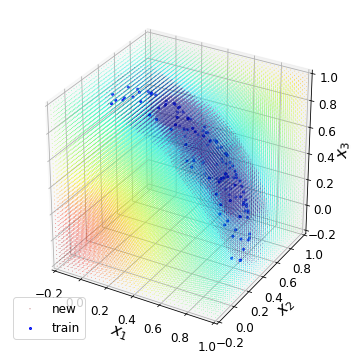

In [12]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], s=0.1, c=plot_penalty, cmap='jet', lw=0.5, label=label2_name)
ax.scatter(train_data[:,0], train_data[:,1], train_data[:,2], marker='o', s=4, edgecolors='blue', label=label1_name)
# ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], s=0.1, edgecolors='orange', lw=0.3, label=label2_name)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_zlim([zmin, zmax])
ax.set_xlabel(x_label_name, fontsize=16)
ax.set_ylabel(y_label_name, fontsize=16)
ax.set_zlabel(z_label_name, fontsize=16)
ax.tick_params(direction = "in")

plt.legend(loc='lower left', fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

## ペナルティModel1 + Model2

In [14]:
mu = 0.5
multi_penalty = penalty+mu*save_penalty
epsilon = epsilon1 + mu * epsilon2
plot_penalty = multi_penalty-epsilon
plot_penalty = np.clip(plot_penalty,0,None)
for it in range(len(plot_penalty)):
  if plot_penalty[it] == 0:
    plot_penalty[it] = -np.max(plot_penalty)/2

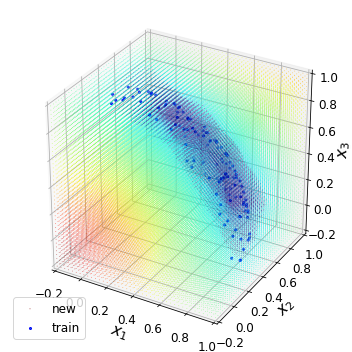

In [15]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], s=0.1, c=plot_penalty, cmap='jet', lw=0.5, label=label2_name)
ax.scatter(train_data[:,0], train_data[:,1], train_data[:,2], marker='o', s=4, edgecolors='blue', label=label1_name)
# ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], s=0.1, edgecolors='orange', lw=0.3, label=label2_name)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_zlim([zmin, zmax])
ax.set_xlabel(x_label_name, fontsize=16)
ax.set_ylabel(y_label_name, fontsize=16)
ax.set_zlabel(z_label_name, fontsize=16)
ax.tick_params(direction = "in")

plt.legend(loc='lower left', fontsize=12)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()